<a href="https://colab.research.google.com/github/Gautam0507/MAT496-Introduction-to-LLMs/blob/main/Project-1/Implementing_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - 1: GPT-2 Implementation
**Done By** : N Gautam  2210110411

In this notebook is my impementation of the  GPT-2 model pretraining

# To use this notebook:
1. Set `run_training = True` to train the model from scratch.  Set `run_training = False` to load pretrained weights and test the model.
3. Click "Run All Cells" or run each cell sequentially.


The last code cell contains the text generation function where you can modify the variable `input_text` to generate a sample ouptut.

In [ ]:
run_training = False

# Importing Libraries

In [ ]:
%%capture
!pip install tiktoken gdown

In [ ]:
from math import log
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import os
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import tiktoken
import gdown

# All Functions and classes necessary

## Preparing the Data

In [ ]:
url = [
    "https://www.gutenberg.org/cache/epub/1342/pg1342.txt",
    "https://www.gutenberg.org/cache/epub/1400/pg1400.txt",
]

In [ ]:
if not os.path.exists("Pride_and_Prejudice.txt"):
    urlretrieve(url[0], "Pride_and_Prejudice.txt")
if not os.path.exists("War_and_Peace.txt"):
    urlretrieve(url[1], "War_and_Peace.txt")

In [ ]:
def create_data(file_name):
    with open(file_name, "r", encoding="utf-8") as f:
        file_content = f.read()  # File content is in string format with encoding
    return file_content

raw_text = (
    create_data("Pride_and_Prejudice.txt")
    + "<|endoftext|>"
    + create_data("War_and_Peace.txt")
    + "<|endoftext|>"
)

## Creating Configuration

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-key-value bias
}

OTHER_SETTINGS = {
    "learning_rate": 5e-4,
    "num_epochs": 10,
    "batch_size": 4,
    "weight_decay": 0.1,
    "stride": 128,
}

## Creating Dataset

In [ ]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])


def create_dataloader(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
    )
    return dataloader

## MultiHeaded Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = (
            d_out // num_heads
        )  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

## Implementing Layer Norm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## Implementing GELU  

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

## Implementing Feed Forward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

## Implementing the Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

## Implementing the GPT Model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Implementing the Text Generation Functions

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate_tokens(
    model, idx, max_new_tokens, context_size, temperature=0.0, top_K=None
):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_K is not None:
            top_logits, _ = torch.topk(logits, top_K)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


def generate_text(
    model,
    tokenizer,
    prompt,
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=0.0,
    top_K=None,
):
    idx = text_to_token_ids(prompt, tokenizer)
    if idx.size(1) > context_size:
        print(
            f"Warning: Input has {idx.size(1)} tokens which exceeds the context size of {context_size}."
        )
        print(f"Only the last {context_size} tokens will be used for generation.")

    idx = idx.to(device)
    idx = generate_tokens(
        model,
        idx,
        max_new_tokens=max_new_tokens,
        context_size=context_size,
        temperature=temperature,
        top_K=top_K,
    )
    return token_ids_to_text(idx, tokenizer)

## Defining Loss for the Model

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

## Defining the function for model training

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    for epoch in tqdm(range(num_epochs)):
        model.train()

        if (epoch + 1 == 7):
          # From the graph we can see the validation error starting
          # to go up at the start of epoch 7 (overfitting)
          torch.save(
              {
                  "model_state_dict": model.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),
              },
              "GPT-2_model_chcekpoint.pth",
          )

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

    return train_losses, val_losses, track_tokens_seen

## Plotting the losses of the model

In [ ]:
def make_plot(epochs_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    fig.tight_layout()
    plt.savefig("loss.png")
    plt.close(fig)  # Close the figure to prevent automatic display

# Training the Model

In [ ]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

if run_training:
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=OTHER_SETTINGS["learning_rate"],
        weight_decay=OTHER_SETTINGS["weight_decay"],
    )

    train_ratio = 0.90
    split_idx = int(train_ratio * len(raw_text))

    train_loader = create_dataloader(
        raw_text[:split_idx],
        batch_size=OTHER_SETTINGS["batch_size"],
        max_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0,
    )

    val_loader = create_dataloader(
        raw_text[split_idx:],
        batch_size=OTHER_SETTINGS["batch_size"],
        max_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0,
    )
    train_losses, val_losses, tokens_seen = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs=OTHER_SETTINGS["num_epochs"],
        eval_freq=10,
        eval_iter=5,
    )

    # Plotting the losses
    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    make_plot(epochs_tensor, train_losses, val_losses)

    # Saving model weights
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "GPT-2_model.pth",
    )

# Loading model weights from pretrained file

In [ ]:
if not run_training:
  if not os.path.isdir("/content/batchsize4"):
    gdown.download_folder("https://drive.google.com/drive/folders/1nNwu1JmUdt9IHMfjXoWds5Pn1kP3t50I?usp=drive_link")

  values = torch.load("/content/batchsize4/GPT-2_model.pth", map_location=device, weights_only=False)
  model.load_state_dict(values["model_state_dict"])

Retrieving folder contents


Processing file 14KMKSn4h_XCd5zU31q5s1DtVRmm2E1RI GPT-2_model_chcekpoint.pth
Processing file 16DWsIsbpCc2zqQcC2r_oY9Y9EGqfhqBy GPT-2_model.pth
Processing file 1XA7alm_ALs7r-ynwSgyljFKsvFAZilf5 pretrained_loss.png
Processing file 1UBuAh3GySD0dgW8GLUFa-ddzBZs2k_ib Project_1_GPT_2.ipynb


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=14KMKSn4h_XCd5zU31q5s1DtVRmm2E1RI
From (redirected): https://drive.google.com/uc?id=14KMKSn4h_XCd5zU31q5s1DtVRmm2E1RI&confirm=t&uuid=968464f2-29c5-42da-aec1-389e8cbc2c55
To: /content/batchsize4/GPT-2_model_chcekpoint.pth
100%|██████████| 2.01G/2.01G [00:16<00:00, 121MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16DWsIsbpCc2zqQcC2r_oY9Y9EGqfhqBy
From (redirected): https://drive.google.com/uc?id=16DWsIsbpCc2zqQcC2r_oY9Y9EGqfhqBy&confirm=t&uuid=18310b13-bae9-44fb-93c4-dac975082519
To: /content/batchsize4/GPT-2_model.pth
100%|██████████| 2.01G/2.01G [00:13<00:00, 144MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XA7alm_ALs7r-ynwSgyljFKsvFAZilf5
To: /content/batchsize4/pretrained_loss.png
100%|██████████| 35.3k/35.3k [00:00<00:00, 43.8MB/s]
Downloading...
From: https://drive.google.com/uc?id

# Displaying the training loss plot

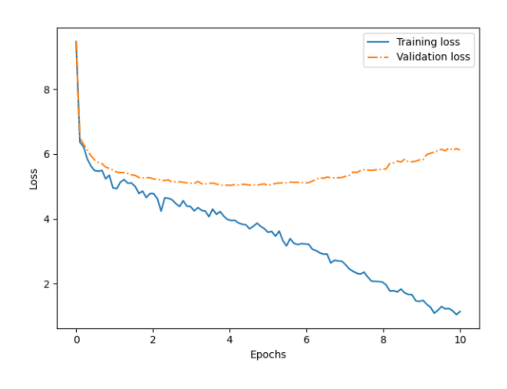

In [ ]:
if run_training:
    plt.figure(figsize=(10, 6))
    img = plt.imread("loss.png")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    try:
        img = plt.imread("/content/batchsize4/pretrained_loss.png")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Could not load pretrained plot: {e}")
        print("Please check the URL or manually download the loss plot")

# Generating text using the model

In [ ]:
# Change the below variable to give input
input_text = """It is a truth universally acknowledged,"""

model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
with torch.no_grad():
    generated_text = generate_text(
        model,
        tokenizer,
        input_text,
        max_new_tokens=25,
        context_size=GPT_CONFIG_124M["context_length"],
        temperature=0.8,
        top_K=10,
    )

print(generated_text)

It is a truth universally acknowledged, as a good, and always let me in my way to you were my one night. I would have no liking for life
